# <center> 🔍 Exploratory Data Analysis </center>

<a id="cont"></a>

## 📑 Table of Contents

<a href="#one">1. Introduction
   - Project Overview

<a href=#two>2. Loading Data
   - Importing libraries
   - Reading the dataset

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#five>4. Feature Engineering</a>

<a href=#six>5. Modeling</a>

<a href=#seven>6. Model Performance</a>

<a href=#eight>7. Model Explanations</a>

<a id="one"></a>
## 1. Introduction
<a href=#cont>Back to Table of Contents</a>


---
    
| ⚡ Description: Introducing the project ⚡ |
| :--------------------------- |

---

### *Project Overview*

#### Objective

The aim of this project is to develop a machine learning model that predicts car insurance premiums based on customer demographics. 

#### Context/Background

Accurate premium predictions ensures transparency and fairness in cost assessment for customers 

#### Dataset Overview

| **Source**       | **Description**                          |
|------------------|-------------------------------------------|
| `data/train.csv`  | Training data with target premiums        |
| `data/test.csv`   | Test data for final predictions           |

<a id="two"></a>
## 📂 2. Loading Data
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data in our environment ⚡ |
| :--------------------------- |

---

### 📚 *Importing libraries*

In [1]:
#Load the packages 
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

### 📖 *Reading the dataset*

In [2]:
train = pd.read_csv("../data/car_insurance_premiums_zar.csv")
test = pd.read_csv("../data/car_insurance_test_set_zar.csv")

#Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,Customer_ID,Age,Gender,Region,Employment_Status,Education_Level,Years_Driving,Car_Make,Car_Model,Manufacture_Year,Annual_Mileage,Number_of_Accidents,Number_of_Claims,Car_Value,Premium_Amount,Marital_Status,Has_AntiTheft_Device,Policy_Term,Credit_Score,Vehicle_Usage
0,1,56,Female,Rural,Retired,Master's Degree,22,Volkswagen,Golf,2000,18319,3,0,1600866,50112,Single,1,12,384,Commute
1,2,69,Female,Urban,Employed,Master's Degree,28,BMW,X5,2003,27863,5,1,1737234,40194,Single,0,12,419,Business
2,3,46,Male,Rural,Self-Employed,Bachelor's Degree,0,Chevrolet,Equinox,2006,14834,1,6,315990,57348,Single,1,12,626,Pleasure
3,4,32,Male,Suburban,Self-Employed,Associate Degree,14,Kia,Forte,2021,24495,3,5,1098846,83502,Widowed,1,6,582,Business
4,5,60,Male,Rural,Employed,Doctorate,14,Volkswagen,Passat,2004,24366,1,6,1209096,14040,Single,1,6,590,Pleasure


(10000, 20)

'Test'

,Customer_ID,Age,Gender,Region,Employment_Status,Education_Level,Years_Driving,Car_Make,Car_Model,Manufacture_Year,Annual_Mileage,Number_of_Accidents,Number_of_Claims,Car_Value,Premium_Amount,Marital_Status,Has_AntiTheft_Device,Policy_Term,Credit_Score,Vehicle_Usage
0,1,38,Female,Suburban,Employed,Bachelor's Degree,20,Hyundai,Santa Fe,1995,25244,2,8,187110,73638,Married,0,12,544,Commute
1,2,32,Female,Suburban,Retired,Bachelor's Degree,60,Kia,Soul,2012,25410,2,4,628632,56070,Single,1,6,811,Pleasure
2,3,27,Female,Rural,Self-Employed,Doctorate,18,Honda,Accord,2014,21579,3,8,915660,76158,Married,1,12,835,Commute
3,4,63,Male,Urban,Employed,Associate Degree,54,Nissan,Rogue,2022,9437,3,5,934020,59724,Divorced,0,12,383,Pleasure
4,5,34,Male,Suburban,Self-Employed,Associate Degree,30,Toyota,Corolla,1996,20697,0,6,378990,12636,Single,0,12,349,Commute


(2000, 20)

In [3]:
#Get a concise summmary of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer_ID           10000 non-null  int64 
 1   Age                   10000 non-null  int64 
 2   Gender                10000 non-null  object
 3   Region                10000 non-null  object
 4   Employment_Status     10000 non-null  object
 5   Education_Level       10000 non-null  object
 6   Years_Driving         10000 non-null  int64 
 7   Car_Make              10000 non-null  object
 8   Car_Model             10000 non-null  object
 9   Manufacture_Year      10000 non-null  int64 
 10  Annual_Mileage        10000 non-null  int64 
 11  Number_of_Accidents   10000 non-null  int64 
 12  Number_of_Claims      10000 non-null  int64 
 13  Car_Value             10000 non-null  int64 
 14  Premium_Amount        10000 non-null  int64 
 15  Marital_Status        10000 non-null 

In [4]:
#Get a concise summary of the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer_ID           2000 non-null   int64 
 1   Age                   2000 non-null   int64 
 2   Gender                2000 non-null   object
 3   Region                2000 non-null   object
 4   Employment_Status     2000 non-null   object
 5   Education_Level       2000 non-null   object
 6   Years_Driving         2000 non-null   int64 
 7   Car_Make              2000 non-null   object
 8   Car_Model             2000 non-null   object
 9   Manufacture_Year      2000 non-null   int64 
 10  Annual_Mileage        2000 non-null   int64 
 11  Number_of_Accidents   2000 non-null   int64 
 12  Number_of_Claims      2000 non-null   int64 
 13  Car_Value             2000 non-null   int64 
 14  Premium_Amount        2000 non-null   int64 
 15  Marital_Status        2000 non-null   

<a id="three"></a>
## 3. 🔍 Exploratory Data Analysis (EDA)
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploring the data ⚡ |
| :--------------------------- |

---

In [5]:
#Check for duplicates in the train set
train_duplicates = train[train.duplicated()]
num_duplicates = len(train_duplicates)
print(f"There are {num_duplicates} duplicates in the train dataset")

There are 0 duplicates in the train dataset


In [6]:
#Check for the distribution of each categorical feature
categorical_columns = train.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    print(f"\nDistribution for {col}")
    print(train[col].value_counts())


Distribution for Gender
Gender
Male      5014
Female    4986
Name: count, dtype: int64

Distribution for Region
Region
Suburban    3398
Rural       3327
Urban       3275
Name: count, dtype: int64

Distribution for Employment_Status
Employment_Status
Retired          2574
Employed         2520
Unemployed       2475
Self-Employed    2431
Name: count, dtype: int64

Distribution for Education_Level
Education_Level
Doctorate            2093
Bachelor's Degree    2027
Master's Degree      1978
Associate Degree     1963
High School          1939
Name: count, dtype: int64

Distribution for Car_Make
Car_Make
Nissan        1029
Hyundai       1026
Mercedes      1023
BMW           1008
Chevrolet     1005
Volkswagen    1002
Kia            991
Toyota         981
Honda          972
Ford           963
Name: count, dtype: int64

Distribution for Car_Model
Car_Model
Soul        372
Equinox     370
E-Class     355
Altima      354
Golf        353
Tucson      350
Elantra     349
Accord      344
Corolla    

* The demographic factors in our dataset are fairly balanced with no significant overrepresentation or underrepresentation of any group meaning that these factors should not introduce any bias into the model training. 

* Vehicle details are also fairly balanced which is ideal for our predictive modelling task.

### Data Quality Checks

#### Education Level

In [7]:
#Determine the unique values that are in the "Education" column
train["Education_Level"].value_counts()

Education_Level
Doctorate            2093
Bachelor's Degree    2027
Master's Degree      1978
Associate Degree     1963
High School          1939
Name: count, dtype: int64

In [8]:
#Replace the "Associate_Degree" category with "Higher Certificate"
train["Education_Level"] = train["Education_Level"].replace("Associate Degree","Higher Certificate")

In [9]:
#Define minimum age requirements for each education level
education_age_limits = {
    "High School": 18,
    "Higher Certificate": 18,
    "Bachelor's Degree": 18,      
    "Master's Degree": 22,                  
    "Doctorate": 24      
}

# Flag invalid rows where age is too low for the education level
invalid_education_rows = train[train.apply(lambda row: row["Age"] < education_age_limits.get(
    row["Education_Level"], 0), axis=1)]

# Display errors
print(invalid_education_rows)

      Customer_ID  Age  Gender    Region Employment_Status  Education_Level  \
54             55   20  Female     Rural        Unemployed  Master's Degree   
62             63   21    Male     Rural           Retired        Doctorate   
71             72   19    Male     Rural           Retired        Doctorate   
87             88   21  Female  Suburban     Self-Employed  Master's Degree   
131           132   18    Male     Rural           Retired        Doctorate   
...           ...  ...     ...       ...               ...              ...   
9825         9826   23  Female  Suburban          Employed        Doctorate   
9837         9838   23    Male     Rural     Self-Employed        Doctorate   
9925         9926   18    Male     Rural           Retired        Doctorate   
9942         9943   20  Female     Rural     Self-Employed  Master's Degree   
9958         9959   19    Male     Rural        Unemployed        Doctorate   

      Years_Driving    Car_Make Car_Model  Manufact

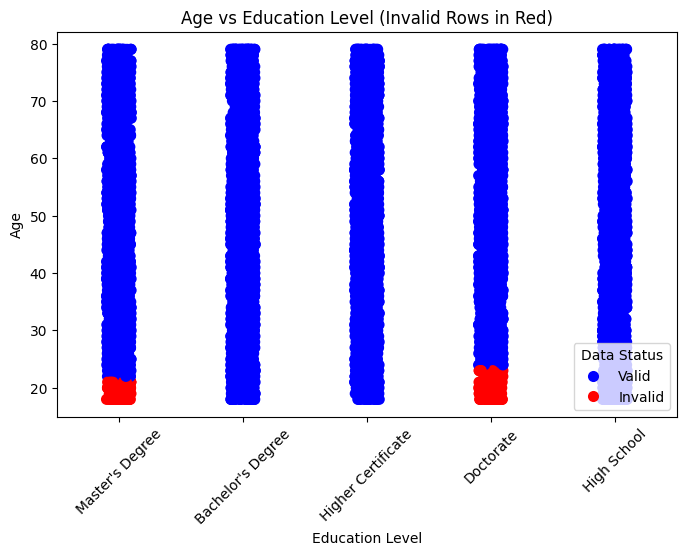

In [10]:
# Create a boolean mask for invalid rows where True = Invalid and False = Valid
hue_values = train.index.isin(invalid_education_rows.index)

# Define color palette explicitly as a dictionary
palette = {True: "red", False: "blue"}

# Plot strip plot
plt.figure(figsize=(8, 5))
ax = sns.stripplot(x=train["Education_Level"],
                   y=train["Age"],
                   hue=hue_values,
                   palette=palette,
                   size=8, jitter=True)

# Fix legend labels manually
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Valid", "Invalid"], title="Data Status")

plt.title("Age vs Education Level (Invalid Rows in Red)")
plt.xlabel("Education Level")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Remove invalid rows from the original DataFrame in place
cleaned_train = train[train.apply(
    lambda row: row["Age"] >= education_age_limits.get(row["Education_Level"], float('inf')), axis=1)]

#Check the shape of the resulting dataset
cleaned_train.shape

(9694, 20)

#### Employment status

In [12]:
#Find the unique categories in the "Employment_Status" column
cleaned_train["Employment_Status"].value_counts()

Employment_Status
Retired          2495
Employed         2429
Unemployed       2413
Self-Employed    2357
Name: count, dtype: int64

In [13]:
#Find the invalid rows in the dataset according to the mimimum age required for an educational level
employment_age_limits = {
    "Unemployed": (18, 65),
    "Employed": (18, 65), 
    "Self-Employed": (18, 80),
    "Retired": (65, 100)
}

invalid_employment_status = cleaned_train[cleaned_train.apply(lambda row: not (employment_age_limits.get(row["Employment_Status"], (0, 150))[0] <= row["Age"] <= employment_age_limits.get(row["Employment_Status"], (0, 150))[1]), axis = 1)]
invalid_employment_status.shape

(3039, 20)

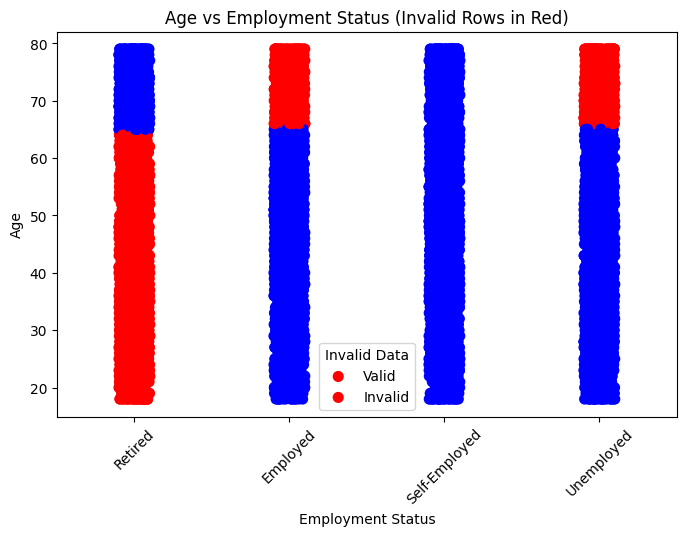

In [14]:
plt.figure(figsize=(8, 5))

# Ensure hue is a 1D Boolean Series
hue_values = cleaned_train.index.isin(
    invalid_employment_status.index)  # Boolean Series

sns.stripplot(x=cleaned_train["Employment_Status"],
              y=cleaned_train["Age"],
              hue=hue_values,  # Fix here
              palette={True: "red", False: "blue"},
              size=8, jitter=True)

plt.title("Age vs Employment Status (Invalid Rows in Red)")
plt.xlabel("Employment Status")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.legend(title="Invalid Data", labels=["Valid", "Invalid"])
plt.show()

The above graph represents a stacked bar graph which highlights logically invalid data points in red and valid ones in blue.
 
 * There is a high number of red points between the ages of 18-55, which are ages that are too young to be considered retired.
 * There are red points in the "Employed" and 'Unemployed" categories for the 65+ age group because it is uncommon to be employed beyond the age of 65.
 * Anyone beyond the age of 65+ would typically be considered "Retired" even if they have been unemployed their entire lives as they are too old to enter the workforce. 

In [15]:
# Set target proportions from original distribution
target_distribution = {
    "Retired": 0.257376,
    "Employed": 0.250567,
    "Unemployed": 0.248917,
    "Self-Employed": 0.243140
}

# Get total number of rows in cleaned_train
total_rows = len(cleaned_train)

# Count how many records we currently have
current_counts = Counter(cleaned_train["Employment_Status"])


def fix_employment_smart(row):
    age = row["Age"]
    current_status = row["Employment_Status"]

    # Is the age valid for this status?
    min_age, max_age = employment_age_limits.get(current_status, (0, 150))
    if min_age <= age <= max_age:
        return current_status  # No fix needed

    # Find all valid statuses for this age
    valid_statuses = [
        status for status, (min_a, max_a) in employment_age_limits.items()
        if min_a <= age <= max_a
    ]

    if not valid_statuses:
        return current_status  # fallback

    # Prefer status that brings us closer to original proportions
    best_status = None
    smallest_gap = float("inf")

    for status in valid_statuses:
        current_prop = current_counts[status] / total_rows
        target_prop = target_distribution.get(status, 0)
        gap = abs(target_prop - current_prop)
        if gap < smallest_gap:
            smallest_gap = gap
            best_status = status

    # Update the count to reflect the new assignment
    current_counts[best_status] += 1

    return best_status

In [16]:
#Apply the function to fix the logical inconsistencies in the "Employment_Status" column
cleaned_train["Employment_Status"] = cleaned_train.apply(fix_employment_smart, axis=1)

# Check final distribution
print(cleaned_train["Employment_Status"].value_counts(normalize=True))

Employment_Status
Self-Employed    0.321539
Employed         0.268723
Unemployed       0.265319
Retired          0.144419
Name: proportion, dtype: float64


In [17]:
#Perform a test to validate that the above function worked
invalid_employment_status = cleaned_train[cleaned_train.apply(lambda row: not (employment_age_limits.get(row["Employment_Status"], (0, 150))[
                                              0] <= row["Age"] <= employment_age_limits.get(row["Employment_Status"], (0, 150))[1]), axis=1)]
if invalid_employment_status.empty:
    print("All employment statuses are valid based on the age ranges")
else:
    print(
        f"❌ Found {len(invalid_employment_status)} invalid rows where employment status does not match the age.")
    display(invalid_employment_status)

All employment statuses are valid based on the age ranges


#### Number of years driving

* The `Years_Driving` column represents the number of years that a person has been driving. 
* Logically, the values in this column can't be larger than the person's age minus 18 as the minimum age to obtain a full driving licence is 18 in South Africa. 
* We will proceed to identify rows in the `Years_Driving` column that are logically inaccurate. 

In [18]:
# Identify rows where years_driving is greater than (age - 18)
invalid_years_driving_rows = cleaned_train[cleaned_train["Years_Driving"] > (
    cleaned_train["Age"] - 18)]
print(invalid_years_driving_rows)

      Customer_ID  Age  Gender    Region Employment_Status  \
5               6   25    Male  Suburban          Employed   
7               8   38  Female     Rural          Employed   
8               9   56    Male     Urban          Employed   
10             11   36    Male     Urban        Unemployed   
12             13   28    Male  Suburban     Self-Employed   
...           ...  ...     ...       ...               ...   
9995         9996   38  Female     Rural        Unemployed   
9996         9997   23    Male     Rural          Employed   
9997         9998   18    Male  Suburban        Unemployed   
9998         9999   21    Male  Suburban     Self-Employed   
9999        10000   28    Male     Rural        Unemployed   

         Education_Level  Years_Driving    Car_Make Car_Model  \
5              Doctorate             27         Kia  Sportage   
7        Master's Degree             41         BMW  3 Series   
8      Bachelor's Degree             39  Volkswagen     Jett

* There are 4573 logically inconsistent rows which account for nearly half of the total rows in the dataset so removing these rows will lead to significant loss of data. 
* We will use a bar graph to visualize the distribution of the logical inconsistencies across various age groups. 

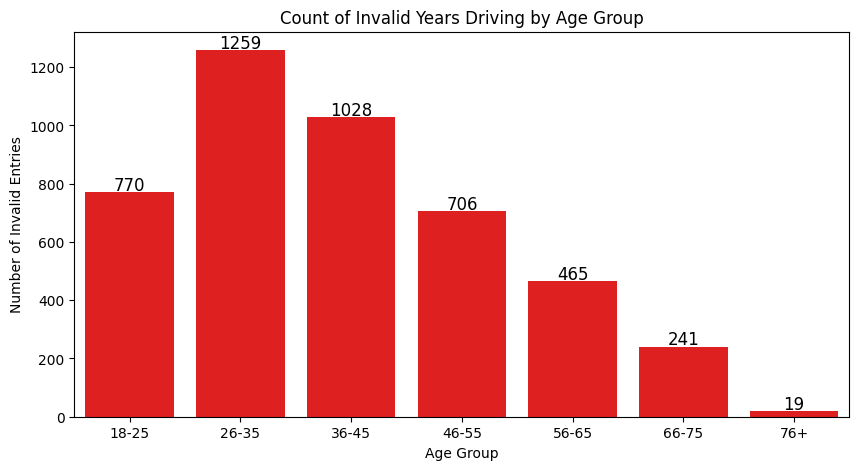

In [19]:
# Define age bins
bins = [18, 25, 35, 45, 55, 65, 75, 100]  # Adjust as needed
labels = ["18-25", "26-35", "36-45", "46-55",
          "56-65", "66-75", "76+"]  # Labels for bins

# Create a new column for age groups
invalid_years_driving_rows["Age_Group"] = pd.cut(
    invalid_years_driving_rows["Age"], bins=bins, labels=labels, right=True)

# Count invalid cases per age group
invalid_counts_grouped = invalid_years_driving_rows["Age_Group"].value_counts(
).sort_index()

# Plot bar chart
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=invalid_counts_grouped.index,
                 y=invalid_counts_grouped.values, color="red")

# Add numbers on top of bars (convert to integer)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Convert to integer
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title("Count of Invalid Years Driving by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Invalid Entries")

plt.show()

* The `18-45` age groups have the top 3 highest logical inconsistencies.  

* We can set the `Years_Driving` to be equal to `Age - 18` if it exceeds that value. 
* This ensures that we do not lose any valuable data while keeping the data consistent.

In [20]:
#Replace any logical inconsistent rows to be within valid range
cleaned_train.loc[cleaned_train["Years_Driving"] > (cleaned_train["Age"] - 18), "Years_Driving"] = cleaned_train["Age"] - 18

* We will now perform a test to determine that all the logical inconsistencies have been fixed by the above function:

In [21]:
#Check whether the Years_Driving column is now within the valid range
invalid_years_driving_rows = cleaned_train[cleaned_train["Years_Driving"] > (
    cleaned_train["Age"] - 18)]
print(invalid_education_rows)

# Display a summary sentence
if invalid_years_driving_rows.empty:
    print("✅ All employment statuses are valid based on the age ranges.")
else:
    print(
        f"❌ Found {len(invalid_years_driving_rows)} invalid rows where employment status does not match the age.")
    display(invalid_years_driving_rows)

      Customer_ID  Age  Gender    Region Employment_Status  Education_Level  \
54             55   20  Female     Rural        Unemployed  Master's Degree   
62             63   21    Male     Rural           Retired        Doctorate   
71             72   19    Male     Rural           Retired        Doctorate   
87             88   21  Female  Suburban     Self-Employed  Master's Degree   
131           132   18    Male     Rural           Retired        Doctorate   
...           ...  ...     ...       ...               ...              ...   
9825         9826   23  Female  Suburban          Employed        Doctorate   
9837         9838   23    Male     Rural     Self-Employed        Doctorate   
9925         9926   18    Male     Rural           Retired        Doctorate   
9942         9943   20  Female     Rural     Self-Employed  Master's Degree   
9958         9959   19    Male     Rural        Unemployed        Doctorate   

      Years_Driving    Car_Make Car_Model  Manufact

#### Median insurance premium amount per annum by car details

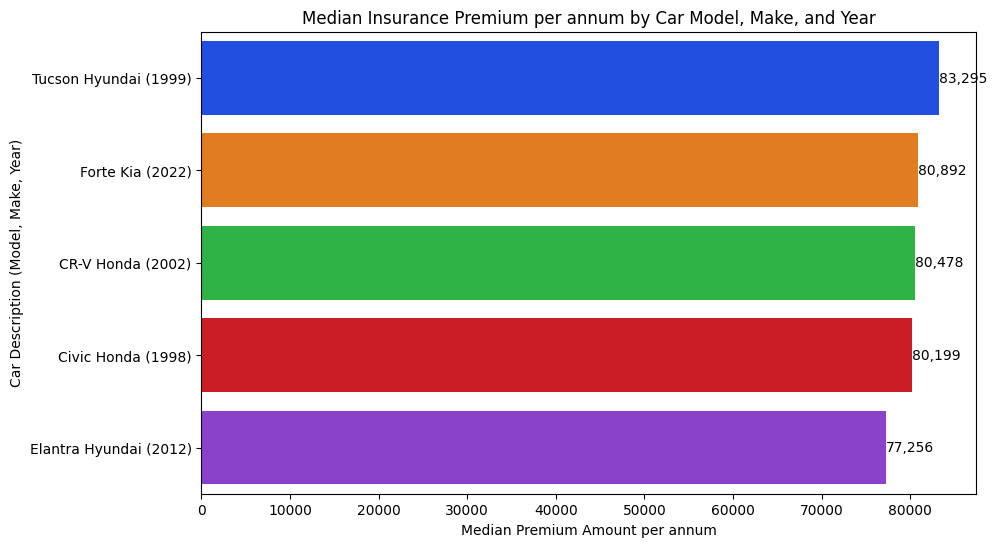

In [22]:
# Group by 'Car_Model', 'Car_Make', 'Manufacture_Year' and calculate the median of 'Premium_Amount'
median_model_premiums = cleaned_train.groupby(
    ["Car_Model", "Car_Make", "Manufacture_Year"])["Premium_Amount"].median().reset_index()

# Create a new column that combines Car_Model, Car_Make, and Manufacture_Year
median_model_premiums['Car_Description'] = (median_model_premiums['Car_Model'] + " " +
                                            median_model_premiums['Car_Make'] + " (" +
                                            median_model_premiums['Manufacture_Year'].astype(str) + ")")

# Sort by 'Premium_Amount' in descending order and select top 5
top_5_models = median_model_premiums.sort_values(
    by="Premium_Amount", ascending=False).head(5)

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(y="Car_Description", x="Premium_Amount",
                 data=top_5_models, palette="bright")

# Add value labels on top of the bars
for index, value in enumerate(top_5_models["Premium_Amount"]):
    plt.text(value, index, f'{value:,.0f}', va="center", fontsize=10)

plt.ylabel("Car Description (Model, Make, Year)")
plt.xlabel("Median Premium Amount per annum")
plt.title("Median Insurance Premium per annum by Car Model, Make, and Year")
plt.show()

The horizontal bar graph displays the top 5 cars with the highest median insurance premium per annum using model, make and year.

* The **Hyundai Tucson(1999)** has the highest median annual premium at **R83,295**. 
    * Older cars sometimes have higher premiums due to expensive parts which may not be readily avaliable or increased risk factors.

* The **Hyundai Elantra(2012)** has the lowest among the top five, at **R77,256**.
    * This can be as a result of better safety features, lower theft rates, or lower repair costs compared to others. 

* The **Kia Forte(2022)** has a high premium(**R83,892**) despite being the newest while the **Civic(1998)** and **CR-V(2002)** also have similar premiums. 
    * This suggests that other factors such as claim history, accident history play a role beyond car age. 

The median premiums are relatively close, implying that factors beyond car type might have a stronger impact. 

#### Distribution of insurance claims by the number of accidents

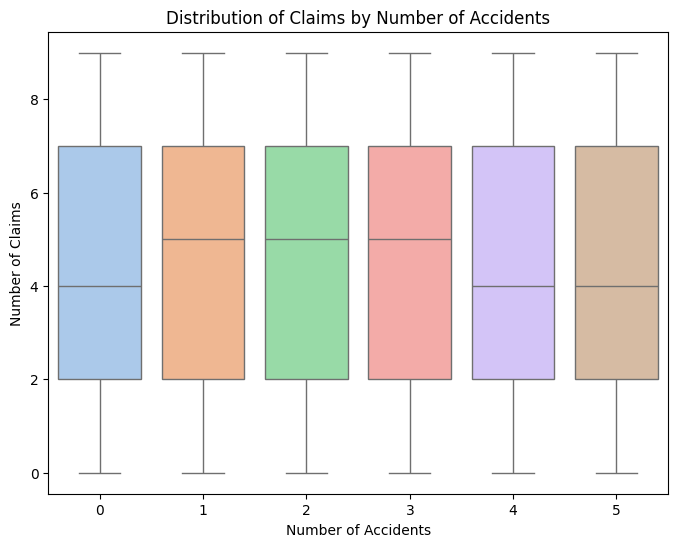

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Number_of_Accidents", y="Number_of_Claims",
            data=train, palette="pastel")
plt.xlabel("Number of Accidents")
plt.ylabel("Number of Claims")
plt.title("Distribution of Claims by Number of Accidents")
plt.show()

The above visual is a box plots showing the distribution of the number of claims across different number of accident categories. 

* The number of claims does not increase linearly with the number of accidents - which is unexpcted for an insurance dataset. 
* This means that other factors such as policy term, years driving may influence clam numbers more than accident count.
* This also suggests that claims may not be strongly correlated with the number of accidents, or at least not in a simple, direct way. 
* Claims can include other incidents besides accidents.
* This could be an indication of potential fraudelent claims, unrreporting of accidents or policyholders have multiple claims from a single accident. 

#### Median premium amount per annum by the number of accidents and claims

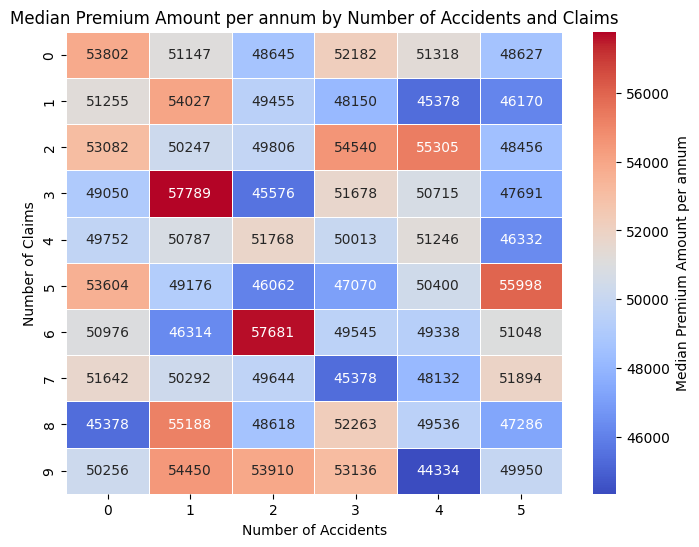

In [24]:
heatmap_data = cleaned_train.pivot_table(
    index="Number_of_Claims",
    columns="Number_of_Accidents",
    values="Premium_Amount",
    aggfunc="median"
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, cbar_kws={"label": "Median Premium Amount per annum"})

plt.xlabel("Number of Accidents")
plt.ylabel("Number of Claims")
plt.title("Median Premium Amount per annum by Number of Accidents and Claims")
plt.show()

The heatmap above displays the median premium amount per annum according to *claim history* and *accident history*. 

* There is no postive linear relationship between the claim history and the accident history which is surprising as one is expected to pay more premiums as the number of claims increase because your risk profile also increases. 
* The highest premium per annum (**R57,996**) has had only one accident and three claims which could be a result of claims from other incidents such as stolen vehicle parts, a weather-related claim or a glass-replacement claim.
* The second highest premium per annum(**R57,681**) has had only six claims and two accidents which are higher than the indivdual with the highest premium.
    * This suggests that other factors may play a bigger role in determining the final insurance premium. 
* The lowest premium per annum (**R44,334**) is from an individual with four accidents and nine claims which is surprising. This can due to a number of reasons: 
    * Long term discounts based on customer loyalty or multiple policies by the same insurer
    * Low-risk driver profile based on demographic factors
    * The claim types are not-at-fault



#### Medium premium amount per annum by years_of_driving

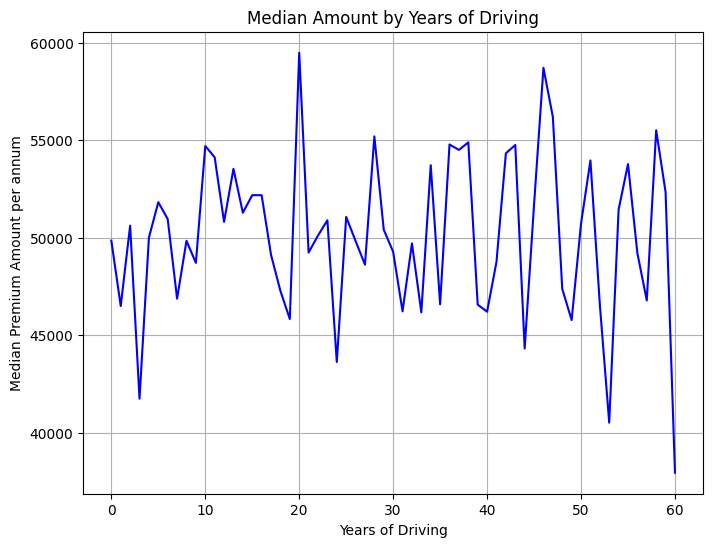

In [25]:
#Visualize the median premium per annum based on the number of years drivibg 
median_years_premiums = cleaned_train.groupby("Years_Driving")["Premium_Amount"].median().reset_index()
plt.figure(figsize=(8, 6))
sns.lineplot(x="Years_Driving", y="Premium_Amount", data=median_years_premiums, color="b")
plt.xlabel("Years of Driving")
plt.ylabel("Median Premium Amount per annum")
plt.title("Median Amount by Years of Driving")
plt.grid(True)
plt.show()

The above line graph displays the median premium amount per annum by years of driving.

* The higest premium amount is from an individual with 20 years of driving experience.
* The lowest premium amount is from an individual with 60 years driving experience. 
* There are varying lengths of premiums amounts as the years of driving increase which could be to a number of reasons:
    * Non-linear risk patterns
    * Claim history vs driving experience
    * Differences in policy terms
    * Insurance company pricing as a result of age, loyalty discounts or market changes. 

There is typically no linear relationship between the two variables indicating that there might be various other factors which have an impact on the final premium amount.

#### Credit score range vs Median premium amount per annum


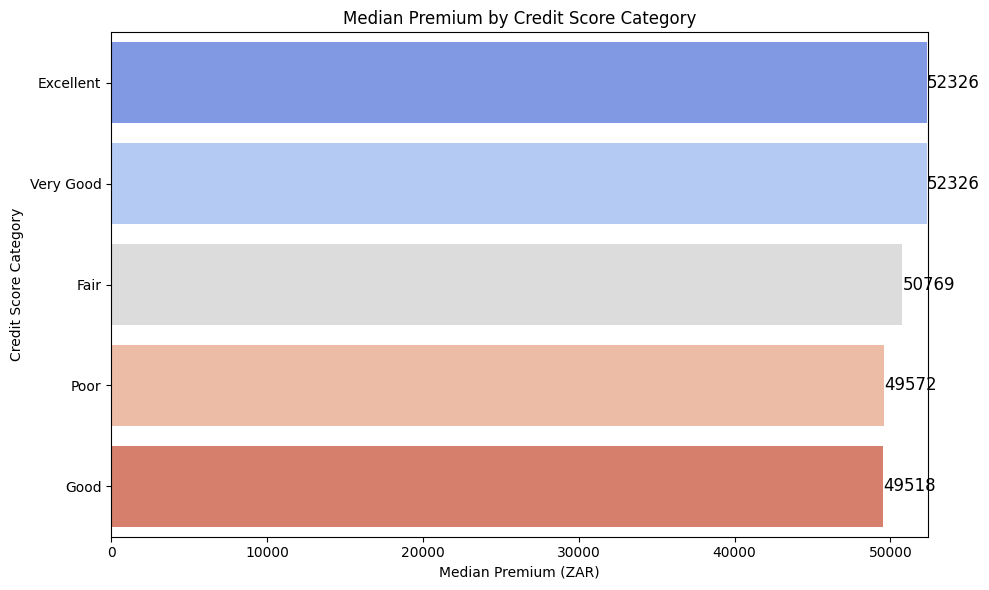

In [ ]:
#Sort the credit scores into categories 
def categorize_credit_score(credit_score):
    if credit_score < 580:
        return "Poor"
    elif 580 <= credit_score < 670:
        return "Fair"
    elif 670 <= credit_score < 740:
        return "Good"
    elif 740 <= credit_score < 800:
        return "Very Good"
    else:
        return "Excellent"


#Apply the function to the main dataset
cleaned_train["Credit_Category"] = cleaned_train["Credit_Score"].apply(
    categorize_credit_score)

#Calculate median premiums for each category
median_premium = cleaned_train.groupby("Credit_Category")[
    "Premium_Amount"].median().sort_values(ascending=False)

#Reorder categories in the dataset based on sorted order
sorted_categories = median_premium.index.tolist()
cleaned_train["Credit_Category"] = pd.Categorical(
    cleaned_train["Credit_Category"],
    categories=sorted_categories,
    ordered=True
)

#Plot using original cleaned_train but sorted categories
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cleaned_train,
    y="Credit_Category",
    x="Premium_Amount",
    estimator="median",
    order=sorted_categories,
    palette="coolwarm",
    ci=None
)

#Add labels to the horizontal bars
for i, (cat, val) in enumerate(median_premium.items()):
    plt.text(val + 20, i, f"{int(val)}", va="center", fontsize=12)

plt.title("Median Premium by Credit Score Category")
plt.ylabel("Credit Score Category")
plt.xlabel("Median Premium (ZAR)")
plt.xlim(0, median_premium.max() + 100)
plt.tight_layout()
plt.show()

The above graph is a horizontal bar graph that represents the median premium amount across six different credit score categories. 

* The results are surprising as one would usually expect the following: 
    * Higher credit score would lead to lower premiums, because insurers usually consiser good credit as a sign of lower risk. 
    * The *Excellent* and *Very Good* credit score categories have the same highest premiums while *Poor* and *Good* have the lowest premiums. 
* Possible explanations for the above observations could be: 
    * Other features dominate risk assessment
    * Correlation with other features - e.g people with excellent credit might be insuring more expensive cars

#### Median premium amount per annum vs anti-theft device

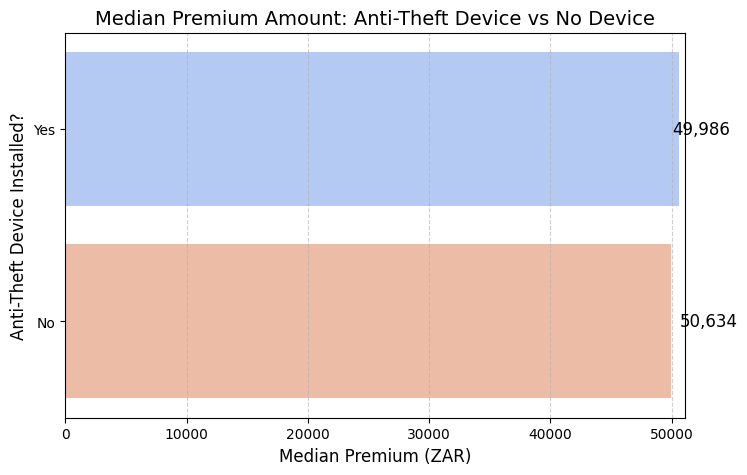

In [32]:
# Group by Anti-Theft Device status and calculate median premium
median_premium_anti_theft = cleaned_train.groupby("Has_AntiTheft_Device")[
    "Premium_Amount"].median().reset_index()

# Sort in descending order (optional)
median_premium_anti_theft = median_premium_anti_theft.sort_values(
    "Premium_Amount", ascending=False)

# Convert the column to categorical for proper ordering
median_premium_anti_theft["Has_AntiTheft_Device"] = median_premium_anti_theft["Has_AntiTheft_Device"].map({
                                                                                                    1: "Yes", 0: "No"})

plt.figure(figsize=(8, 5))

# Create horizontal bar chart
sns.barplot(y="Has_AntiTheft_Device", x="Premium_Amount",
            data=median_premium_anti_theft, palette="coolwarm")

# Add labels with thousands separator
for index, row in median_premium_anti_theft.iterrows():
    plt.text(row.Premium_Amount + 50, index,  # Offset label for readability
             f"{row.Premium_Amount:,.0f}",  # Format numbers with commas
             ha="left", va="center", fontsize=12, color="black")

plt.title("Median Premium Amount: Anti-Theft Device vs No Device", fontsize=14)
plt.ylabel("Anti-Theft Device Installed?", fontsize=12)
plt.xlabel("Median Premium (ZAR)", fontsize=12)

# Adjust x-axis limits for better spacing
plt.xlim(0, median_premium_anti_theft["Premium_Amount"].max() + 500)

# Light grid lines for readability
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

The above graph is a categorical bar graph that displays the median premium per annum of individuals who have anti-theft device vs. those without it. 
* The median premiums are very similar which suggests that other features play a more significant role in determining the premium.
* Typically, having an anti-theft device lowers your risk profile as it improves vehicle security, aids in recovery when stolen thus potentially reducing insurance costs. 

#### Correlation Heatmap

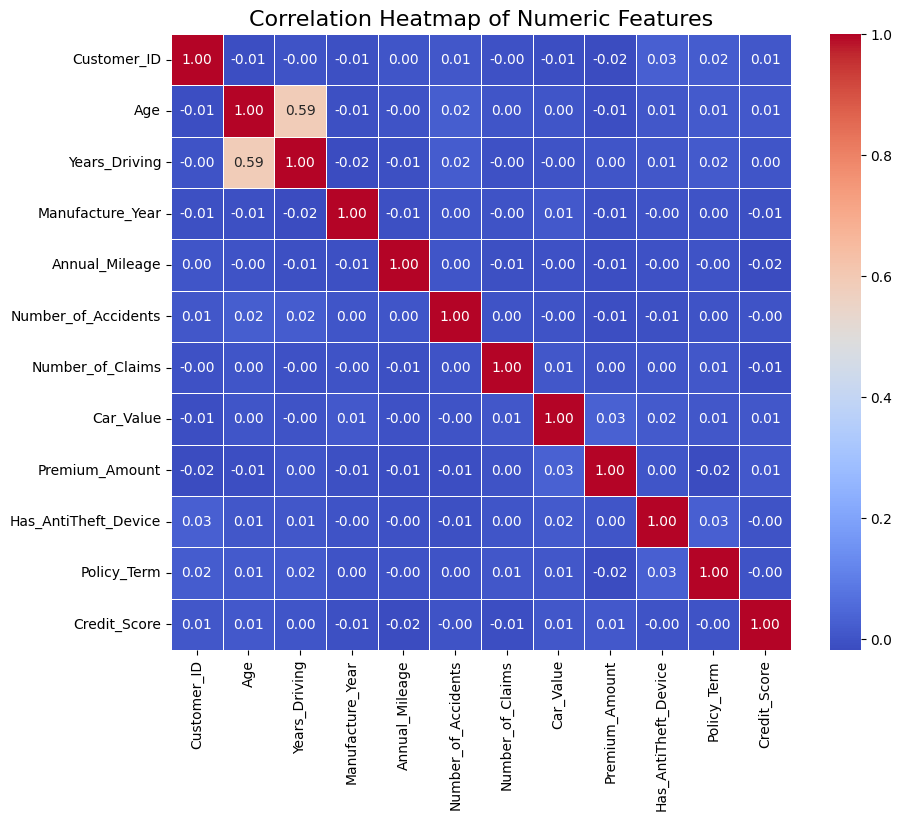

In [33]:
numeric_train_columns = cleaned_train.select_dtypes(include=[np.number])
correlation_matrix = numeric_train_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

The above visual represents the correlation heatmap of the numeric features in our dataset.
* There is a positive moderate correlation between the age and the years_driving feature. 
    * This means that as the age increases, the years_driving column also increases(or vice versa)
    * This is due to the fact that the years_driving feature is dependent on age it measures the number of years an individual has been driving since they turned 18. 
* There is no correlation across all the other features indicating that there exists a non-linear relationship. 

### Five-number summary

In [34]:
cleaned_train.describe()

,Customer_ID,Age,Years_Driving,Manufacture_Year,Annual_Mileage,Number_of_Accidents,Number_of_Claims,Car_Value,Premium_Amount,Has_AntiTheft_Device,Policy_Term,Credit_Score
count,9694.000000,9694.000000,9694.000000,9694.000000,9694.000000,9694.000000,9694.000000,9.694000e+03,9694.000000,9694.000000,9694.000000,9694.000000
mean,5007.357747,49.705797,20.946049,2008.533423,17606.804415,2.474108,4.479781,9.424805e+05,49958.012172,0.493192,9.069940,572.152362
std,2884.306022,17.425679,14.616882,8.059722,7216.406490,1.703765,2.888762,4.882766e+05,23432.322385,0.499979,2.999339,158.457930
min,1.000000,18.000000,0.000000,1995.000000,5000.000000,0.000000,0.000000,9.001800e+04,9000.000000,0.000000,6.000000,300.000000
25%,2508.250000,35.000000,9.000000,2001.000000,11387.250000,1.000000,2.000000,5.240970e+05,29830.500000,0.000000,6.000000,434.000000
50%,5018.500000,50.000000,19.000000,2009.000000,17497.500000,2.000000,5.000000,9.440820e+05,50247.000000,0.000000,12.000000,573.000000
75%,7501.750000,65.000000,31.000000,2015.000000,23894.750000,4.000000,7.000000,1.358240e+06,70128.000000,1.000000,12.000000,710.000000
max,10000.000000,79.000000,60.000000,2022.000000,29999.000000,5.000000,9.000000,1.799964e+06,89982.000000,1.000000,12.000000,849.000000


* The five-number summary above provides a quick summary of the dataset. These include the minimum, first quartile, median, third quartile, and maximum. 
* This helps identify any potential outliners and gives insights into the data's central tendency and spread.

<a id="four"></a>
## ⚙️ 4. Feature Engineering
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Transforming our data ⚡ |
| :--------------------------- |

---